In [1]:
import pandas as pd
import numpy as np
import tweepy
import requests
import json
import os
import re
from pandas import DataFrame
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Gathering Data




In [3]:
# read weRateDogs twitter_archive_enhanced.csv
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [2]:
# read image-predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
img_predict_file = url.split('/')[-1]
response = requests.get(url)
if not os.path.isfile(img_predict_file):
    with open(img_predict_file, 'wb') as file:
        file.write(response.content)
image_prediction_df = pd.read_csv(img_predict_file,sep = '\t')
image_prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [4]:
image_prediction_df.tweet_id.duplicated().sum()

0

In [5]:
# read tweet_json.txt instead of using twitter API
df_list=[]
with open('tweet-json.txt','r') as file:
    for line in file:
        data = json.loads(line)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        created_at = data['created_at']
        #img_url = data['entities']['media'][0]['expanded_url']
        df_list.append({'tweet_id':tweet_id, 'retweet_count':retweet_count,
                        'favorite_count':favorite_count,
                       'created_at':created_at})

tweets_df = pd.DataFrame(df_list, columns = ['tweet_id','retweet_count',
                                             'favorite_count','created_at'])
tweets_df.head()

,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,8853,39467,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,6514,33819,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,4328,25461,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,8964,42908,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,9774,41048,Sat Jul 29 16:00:24 +0000 2017


In [7]:
twitter_archive.head()
# NaN values are dispalyed as (None) string in 
#[name, doggo, floofer, pupper, puppo] columns
#Quality issue

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
twitter_archive.tail()
# source column containg the source url 
# should be changed to disprective name indicating it's a url
# Quality issue

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [7]:
twitter_archive.sample(10)
# some dogs have no valid names (a, an, ....)
# Quality Issue

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1077,739544079319588864,NaN,NaN,2016-06-05 19:47:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Tyrannosaurus rex. We only rate d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739544079...,10,10,None,None,None,None,None
2160,669567591774625800,NaN,NaN,2015-11-25 17:25:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Kollin. He's a Parakeetian Badminton from...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669567591...,9,10,Kollin,None,None,None,None
726,782598640137187329,NaN,NaN,2016-10-02 15:10:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Timmy. He's quite large. According to ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782598640...,11,10,Timmy,None,None,None,None
86,875747767867523072,NaN,NaN,2017-06-16 16:11:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Goose. He's a womanizer. Cheeky as h*c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/875747767...,13,10,Goose,None,None,None,None
262,842765311967449089,NaN,NaN,2017-03-17 15:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Indie. She's not a fan of baths but she's...,NaN,NaN,NaN,"https://www.gofundme.com/get-indie-home/,https...",12,10,Indie,None,None,None,None
1000,747963614829678593,NaN,NaN,2016-06-29 01:23:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747963614...,10,10,None,None,None,pupper,None
1121,730924654643314689,NaN,NaN,2016-05-13 00:56:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending non-canine...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/730924654...,9,10,unacceptable,None,None,None,None
1263,710117014656950272,NaN,NaN,2016-03-16 14:54:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper got her hair chalked for her birth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710117014...,11,10,None,None,None,pupper,None
1522,690649993829576704,NaN,NaN,2016-01-22 21:39:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hazel. She's a gymnast. Training hard ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690649993...,11,10,Hazel,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None


In [8]:
twitter_archive.name.value_counts()
# (a) got  55 records
# (an) got 7 records
# (the) got 8 records

None        745
a            55
Charlie      12
Lucy         11
Oliver       11
Cooper       11
Penny        10
Tucker       10
Lola         10
Winston       9
Bo            9
the           8
Sadie         8
Bailey        7
an            7
Buddy         7
Daisy         7
Toby          7
Leo           6
Bella         6
Jack          6
Dave          6
Rusty         6
Oscar         6
Stanley       6
Koda          6
Milo          6
Scout         6
Jax           6
George        5
           ... 
Einstein      1
Mosby         1
Emmie         1
Akumi         1
Heinrich      1
Evy           1
Finnegus      1
Boston        1
Jeremy        1
Banditt       1
Brady         1
Jim           1
Lilah         1
Tiger         1
by            1
Kenzie        1
Kona          1
Antony        1
Bilbo         1
Tessa         1
Gòrdón        1
Dixie         1
Oreo          1
General       1
Jennifur      1
Odin          1
Shooter       1
Skye          1
Tobi          1
Coleman       1
Name: name, Length: 957,

In [9]:
# display the dogs with name (a)
twitter_archive[twitter_archive.name == 'a']
# (a, an, the) names are extracted wrongly from the text

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715733265...,10,10,a,None,None,None,None
1340,704859558691414016,NaN,NaN,2016-03-02 02:43:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704859558...,10,10,a,None,None,pupper,None


In [10]:
twitter_archive.info()
# this project is not counting the retweets ratings, so we will drop them
# timestamp column is displayed as string not a datetime formt
# expanded_urls has missing values, we shall drop the misssing data
# Quality issues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
twitter_archive.duplicated().sum()
# no duplicated rows (that's great)

0

## Assessing
     
     ## Quality
     
     ** twitter_archive file
     1- source column has a non-descriptive name (should be url) and displayed without <a> tag
     2- rating process is not counting on the retweets records, so we shal drop them
     3- some rating_denominator not divided by 10, we have denominator of (7,2,11). 
     4- some ratings are modified in the tweet text [rating with denominator (2 and 11)], should be extarcted
     5- NaN values are dispalyed as None) string in [name, doggo, floofer, pupper, puppo] columns
     6- change wrong names [ a , an , the, all, ... ] as NaN in 
       witter_archive, wrong names are those witten in lower case
     7- timestamp column appears as string
     8- The rating_numerator column should of type float and properly extract the float value
     9- we don't have a clear columns shows the rate as a score
     
     ** tweet-json.txt file
     10- creates_at timestamp column appears as string
     image_prediction file
     
     
     
     ## Tidiness
     
     ** twitter_archive file
     1- dog classification display in one column
     ** creating master dataframe
     2- All the 3 datasets are part of same observational unit. So merging 3
     tables into 1 will be tidiness issue
     

In [12]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [13]:
twitter_archive[twitter_archive.rating_denominator == 110]['text']

1635    Someone help the girl is being mugged. Several...
Name: text, dtype: object

In [14]:
twitter_archive_clean = twitter_archive.copy()
twitter_archive_clean.sample(3);

## Cleaning
Quality

*define
    
    ** twitter_archive file
        1- change column name from source to url and extract the url from the a tag
        
*code     


In [15]:
twitter_archive_clean.source = twitter_archive_clean.source.str.extract('.+"(http.+)" rel?',expand=True)
twitter_archive_clean.rename(columns={'source': 'url'},inplace=True)

*test

In [16]:
twitter_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,url,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1980,672975131468300288,NaN,NaN,2015-12-05 03:05:49 +0000,http://twitter.com/download/iphone,This is Chuckles. He is one skeptical pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672975131...,10,10,Chuckles,None,None,pupper,None
1995,672594978741354496,NaN,NaN,2015-12-04 01:55:13 +0000,http://twitter.com/download/iphone,Meet Scott. Just trying to catch his train to ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672594978...,9,10,Scott,None,None,pupper,None
2211,668614819948453888,NaN,NaN,2015-11-23 02:19:29 +0000,http://twitter.com/download/iphone,Here is a horned dog. Much grace. Can jump ove...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668614819...,7,10,a,None,None,None,None
894,759197388317847553,NaN,NaN,2016-07-30 01:22:17 +0000,http://twitter.com/download/iphone,This is Luna. She's just heckin precious af I ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/759197388...,12,10,Luna,None,None,None,None
1836,676098748976615425,NaN,NaN,2015-12-13 17:57:57 +0000,http://twitter.com/download/iphone,Extremely rare pup here. Very religious. Alway...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676098748...,3,10,None,None,None,None,None
1523,690607260360429569,6.903413e+17,4.670367e+08,2016-01-22 18:49:36 +0000,http://twitter.com/download/iphone,12/10 @LightningHoltt,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
2022,672068090318987265,NaN,NaN,2015-12-02 15:01:33 +0000,http://twitter.com/download/iphone,Say hello to Gizmo. He's upset because he's no...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672068090...,7,10,Gizmo,None,None,None,None
1383,700847567345688576,NaN,NaN,2016-02-20 01:00:55 +0000,http://twitter.com/download/iphone,Meet Crouton. He's a Galapagos Boonwiddle. Has...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700847567...,10,10,Crouton,None,None,None,None
2121,670408998013820928,NaN,NaN,2015-11-28 01:08:55 +0000,http://twitter.com/download/iphone,This is Peanut. He was the World Table Tennis ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670408998...,10,10,Peanut,None,None,None,None
228,848213670039564288,8.482121e+17,4.196984e+09,2017-04-01 16:41:12 +0000,http://twitter.com/download/iphone,Jerry just apuppologized to me. He said there ...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None


## Cleaning
Quality

*define
    
    ** twitter_archive file
        2- delete retweets records from twitter_archive

*code 

In [17]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['expanded_urls']
                                              .notna()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['in_reply_to_status_id']
                                              .isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id']
                                              .isnull()]
twitter_archive_clean = twitter_archive_clean.drop(columns=['in_reply_to_status_id',
                                                            'retweeted_status_id','in_reply_to_user_id',
                                                            'retweeted_status_user_id','retweeted_status_timestamp'])

In [18]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'url', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

## Cleaning
Quality
define

    3- Modify values for rating denominator not divided by 10 in twitter_archive
    4- get the proper modified rating from the tweet text
    

    delete rating_denominator = 7 for dog "Sam" 
    correct the  rating_denominator[11,2]
code

In [19]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['rating_denominator'] != 7]

twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 775096608509886464, 'rating_numerator'] = 14
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 775096608509886464, 'rating_denominator'] = 10
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 740373189193256964, 'rating_numerator'] = 14
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 740373189193256964, 'rating_denominator'] = 10
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 682962037429899265, 'rating_numerator'] = 10
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 682962037429899265, 'rating_denominator'] = 10
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 666287406224695296, 'rating_numerator'] = 9
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == 666287406224695296, 'rating_denominator'] = 10

In [20]:
twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 7];
twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 11]


,tweet_id,timestamp,url,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Cleaning and tidiness
dog calssification columns resolve none values and tidiness in one column in one step

*define
    ** twitter_archive file
    
    Cleaning
    
    5- change None to empty text to be concatinated to one column in [doggo, floofer, pupper, puppo] columns
    change None to np.nan in name column and rename multiple classes to "multiple"
    
    Tidiness 
    1- display the four columns [doggo, floofer, pupper, puppo] in one column dog_classification

*code  

In [21]:
twitter_archive_clean.doggo = twitter_archive_clean.doggo.str.replace('None',"");
twitter_archive_clean.floofer = twitter_archive_clean.floofer.str.replace('None',"");
twitter_archive_clean.pupper = twitter_archive_clean.pupper.str.replace('None',"");
twitter_archive_clean.puppo = twitter_archive_clean.puppo.str.replace('None',"");
twitter_archive_clean['dog_classification'] = (twitter_archive_clean.doggo + 
                                               twitter_archive_clean.floofer
                                               + twitter_archive_clean.pupper + 
                                               twitter_archive_clean.puppo)
twitter_archive_clean.drop(['pupper','doggo','puppo','floofer'], axis = 'columns',inplace = True)
twitter_archive_clean.replace('None',np.NaN , inplace=True);


In [22]:
# replacing 'doggopupper','doggofloofer','doggopuppo' to multiple
twitter_archive_clean.dog_classification.value_counts()
twitter_archive_clean.loc[twitter_archive_clean.dog_classification == 'doggopupper',
                          'dog_classification'] = 'multiple'
twitter_archive_clean.loc[twitter_archive_clean.dog_classification == 'doggofloofer',
                          'dog_classification'] = 'multiple'
twitter_archive_clean.loc[twitter_archive_clean.dog_classification == 'doggopuppo',
                          'dog_classification'] = 'multiple'

In [55]:
twitter_archive_clean.replace('',np.NaN , inplace=True);
twitter_archive_clean.dog_classification.value_counts()

pupper       245
doggo         83
puppo         29
mulitiple     14
floofer        9
Name: dog_classification, dtype: int64

*test

## Cleaning

Quality

define
   
       6- change wrong names [ a , an , the, all, ... ] as NaN in 
       witter_archive, wrong names are those witten in lower case
   
code


In [23]:
twitter_archive_clean.loc[twitter_archive_clean.name.str.islower()==True] = np.NaN

In [24]:
twitter_archive_clean.name.value_counts()

Lucy        11
Charlie     11
Cooper      10
Oliver      10
Penny        9
Tucker       9
Sadie        8
Lola         8
Winston      8
Toby         7
Daisy        7
Bailey       6
Bella        6
Stanley      6
Oscar        6
Koda         6
Bo           6
Jax          6
Scout        5
Leo          5
Chester      5
Louis        5
Milo         5
Dave         5
Rusty        5
Bentley      5
Buddy        5
Phil         4
Finn         4
Jeffrey      4
            ..
Lucia        1
Comet        1
Snoopy       1
Cuddles      1
Bruno        1
Jeremy       1
Antony       1
Kona         1
Mac          1
Jazz         1
Ronnie       1
Kota         1
Shelby       1
Halo         1
Nollie       1
Tebow        1
Rilo         1
Ralphson     1
Dutch        1
Kenzie       1
Ambrose      1
Reptar       1
Banditt      1
Brady        1
Balto        1
Jim          1
Lilah        1
Travis       1
Tiger        1
Coleman      1
Name: name, Length: 929, dtype: int64

## Cleaning

Quality

define
   
       7- convert timestamp column to datetime
   
code

In [25]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

In [26]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              1989 non-null float64
timestamp             1989 non-null datetime64[ns]
url                   1989 non-null object
text                  1989 non-null object
expanded_urls         1989 non-null object
rating_numerator      1989 non-null float64
rating_denominator    1989 non-null float64
name                  1389 non-null object
dog_classification    1989 non-null object
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 163.5+ KB


## Cleaning

Quality

define
   
       8- extract the float value for rating_numinator from the tweet text
   
code

In [27]:
twitter_archive_clean.rating_numerator = twitter_archive_clean.text.str.extract(r"(\d+\.?\d*)\/\d+",
                                                                                expand=True).astype(float)

In [28]:
#test
twitter_archive_clean.info()
twitter_archive_clean.rating_numerator.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              1989 non-null float64
timestamp             1989 non-null datetime64[ns]
url                   1989 non-null object
text                  1989 non-null object
expanded_urls         1989 non-null object
rating_numerator      1989 non-null float64
rating_denominator    1989 non-null float64
name                  1389 non-null object
dog_classification    1989 non-null object
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 163.5+ KB


12.00      470
10.00      411
11.00      397
13.00      280
9.00       139
8.00        91
7.00        46
14.00       34
5.00        32
6.00        30
3.00        18
4.00        13
2.00         7
1.00         4
84.00        1
13.50        1
0.00         1
420.00       1
1776.00      1
80.00        1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
45.00        1
165.00       1
50.00        1
Name: rating_numerator, dtype: int64

## Cleaning

Quality

define
   
       9- create a column showing the rate score from rating_numinator and
       rating_denominator columns
       
code

In [29]:
twitter_archive_clean['dog_rating_score']=twitter_archive_clean.rating_numerator/twitter_archive_clean.rating_denominator

In [31]:
twitter_archive_clean.info();
twitter_archive_clean.dog_rating_score.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              1989 non-null float64
timestamp             1989 non-null datetime64[ns]
url                   1989 non-null object
text                  1989 non-null object
expanded_urls         1989 non-null object
rating_numerator      1989 non-null float64
rating_denominator    1989 non-null float64
name                  1389 non-null object
dog_classification    1989 non-null object
dog_rating_score      1989 non-null float64
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 179.9+ KB


1.200      472
1.000      413
1.100      402
1.300      280
0.900      140
0.800       91
0.700       46
1.400       34
0.500       32
0.600       30
0.300       18
0.400       12
0.200        8
0.100        4
0.975        1
1.350        1
1.127        1
1.126        1
177.600      1
42.000       1
0.000        1
Name: dog_rating_score, dtype: int64

In [32]:
tweets_df_clean = tweets_df.copy()

In [33]:
tweets_df_clean.head()

,tweet_id,retweet_count,favorite_count,created_at
0,892420643555336193,8853,39467,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,6514,33819,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,4328,25461,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,8964,42908,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,9774,41048,Sat Jul 29 16:00:24 +0000 2017


In [34]:
tweets_df_clean.tail()

,tweet_id,retweet_count,favorite_count,created_at
2349,666049248165822465,41,111,Mon Nov 16 00:24:50 +0000 2015
2350,666044226329800704,147,311,Mon Nov 16 00:04:52 +0000 2015
2351,666033412701032449,47,128,Sun Nov 15 23:21:54 +0000 2015
2352,666029285002620928,48,132,Sun Nov 15 23:05:30 +0000 2015
2353,666020888022790149,532,2535,Sun Nov 15 22:32:08 +0000 2015


In [35]:
tweets_df_clean.info()
# created_at column should be displayed as datetime format
#Quality issue
twitter_archive_clean.loc[twitter_archive_clean.name.str.islower()==True] = np.NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
created_at        2354 non-null object
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [36]:
tweets_df_clean.duplicated().sum()
# no duplicated rows

0

## Cleaning

#tweet-json.txt

Quality

define
   
       10- change creates_at timestamp column to datetime
       
code


In [37]:
tweets_df_clean['created_at'] = pd.to_datetime(tweets_df_clean['created_at'])

In [38]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
created_at        2354 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 73.6 KB


In [39]:
image_prediction_df_clean = image_prediction_df.copy()

In [40]:
image_prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [41]:
image_prediction_df.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [42]:
image_prediction_df.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [43]:
image_prediction_df_clean.info()
# change column names to be disprective 
# quality issue

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [44]:
image_prediction_df.duplicated().sum()
# no duplicated rows

0

In [45]:
#since p1 is the most confident prediction we will drop p2 and p3 columns
image_prediction_df_clean = image_prediction_df_clean.drop(columns=['p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog','jpg_url'])

In [46]:
#changing column names 
image_prediction_df_clean = image_prediction_df_clean.rename(columns={'p1':'dog_class_prediction',
                                          'p1_conf':'dog_prediction_conf',
                                          'p1_dog':'is_dog_prediction'})
image_prediction_df_clean.columns

Index(['tweet_id', 'img_num', 'dog_class_prediction', 'dog_prediction_conf',
       'is_dog_prediction'],
      dtype='object')

## Tidiness Issue
#### define
merge 3 tables into 1 
#### code

In [47]:
#merge twitter_archive_clean and tweets_df_clean then merge image_prediction_df_clean
twitter_archive_clean = twitter_archive_clean.merge(tweets_df_clean,
                                                    on=['tweet_id'],how='left')
twitter_archive_clean = twitter_archive_clean.merge(image_prediction_df_clean,
                                                    on=['tweet_id'],how='left')

In [48]:
# test
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'url', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_classification',
       'dog_rating_score', 'retweet_count', 'favorite_count', 'created_at',
       'img_num', 'dog_class_prediction', 'dog_prediction_conf',
       'is_dog_prediction'],
      dtype='object')

In [49]:
#store the master df to csv file
twitter_archive_clean.to_csv('twitter_archive_master.csv',index=False)

## Driving Insights and Visualization

In [51]:
WeRateDogs_master_df = pd.read_csv('twitter_archive_master.csv')

count    1989.000000
mean        1.173745
std         4.068496
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: dog_rating_score, dtype: float64

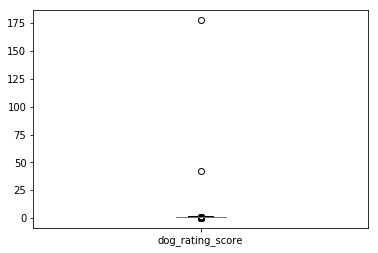

In [52]:
WeRateDogs_master_df['dog_rating_score'].plot(kind = 'box');
WeRateDogs_master_df['dog_rating_score'].describe()

In [53]:
WeRateDogs_master_df.dog_rating_score.value_counts()

1.200      472
1.000      413
1.100      402
1.300      280
0.900      140
0.800       91
0.700       46
1.400       34
0.500       32
0.600       30
0.300       18
0.400       12
0.200        8
0.100        4
0.975        1
1.350        1
1.127        1
1.126        1
177.600      1
42.000       1
0.000        1
Name: dog_rating_score, dtype: int64

In [54]:
# 1st high score winner dog is Atticus with score 177.6
WeRateDogs_master_df[WeRateDogs_master_df.dog_rating_score == 177.6]

,tweet_id,timestamp,url,text,expanded_urls,rating_numerator,rating_denominator,name,dog_classification,dog_rating_score,retweet_count,favorite_count,created_at,img_num,dog_class_prediction,dog_prediction_conf,is_dog_prediction
767,7.499813e+17,2016-07-04 15:00:45,https://about.twitter.com/products/tweetdeck,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,NaN,177.6,2772.0,5569.0,2016-07-04 15:00:45,1.0,bow_tie,0.533941,False


In [56]:
# puppo dogs have the higher rating score in average
WeRateDogs_master_df.groupby('dog_classification').mean()['dog_rating_score']

dog_classification
doggo       1.184286
floofer     1.188889
multiple    1.120000
pupper      1.070464
puppo       1.200000
Name: dog_rating_score, dtype: float64

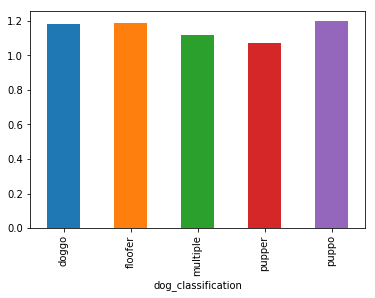

In [57]:
# puppo dogs have the higher rating score in average
WeRateDogs_master_df.groupby('dog_classification').mean()['dog_rating_score'
                                                         ].plot(kind='bar')

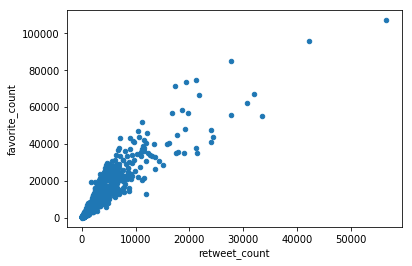

In [58]:
WeRateDogs_master_df.plot(x='retweet_count',y='favorite_count',kind='scatter')
# retweet_count and favorite_count got a poitive correlation

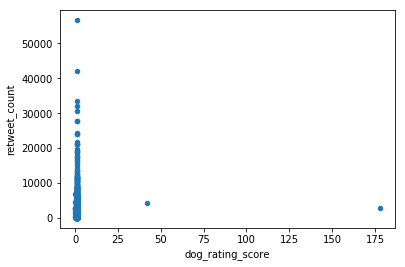

In [59]:
WeRateDogs_master_df.plot(x='dog_rating_score',y='retweet_count',kind='scatter');

### removing outliers and replot dog_rating vs retweet_counts

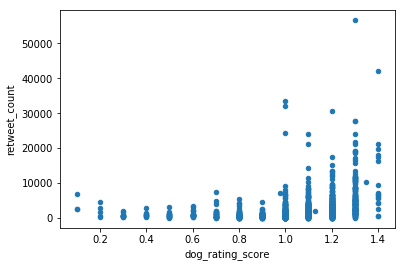

In [60]:
WeRateDogs_master_df[WeRateDogs_master_df.dog_rating_score < 40].plot(x='dog_rating_score',y='retweet_count',kind='scatter');

#### After removing outliers and replot dog_rating vs retweet_counts
#### a positive correlation is found between  dog_rating vs retweet_counts

In [67]:
#pupper dogs have the max rating score
WeRateDogs_master_df.groupby('dog_classification').max()['dog_rating_score']

dog_classification
doggo       1.4
floofer     1.3
multiple    1.3
pupper      1.4
puppo       1.4
Name: dog_rating_score, dtype: float64

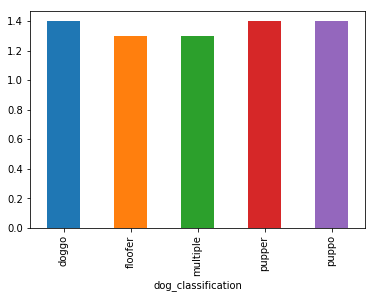

In [63]:
WeRateDogs_master_df.groupby('dog_classification').max()['dog_rating_score'
                                                        ].plot(kind='bar')

#### it seems floofer dogs has the lowest max rating-score with value 1.3 , while the other dogs got a max rating-score of 1.4 

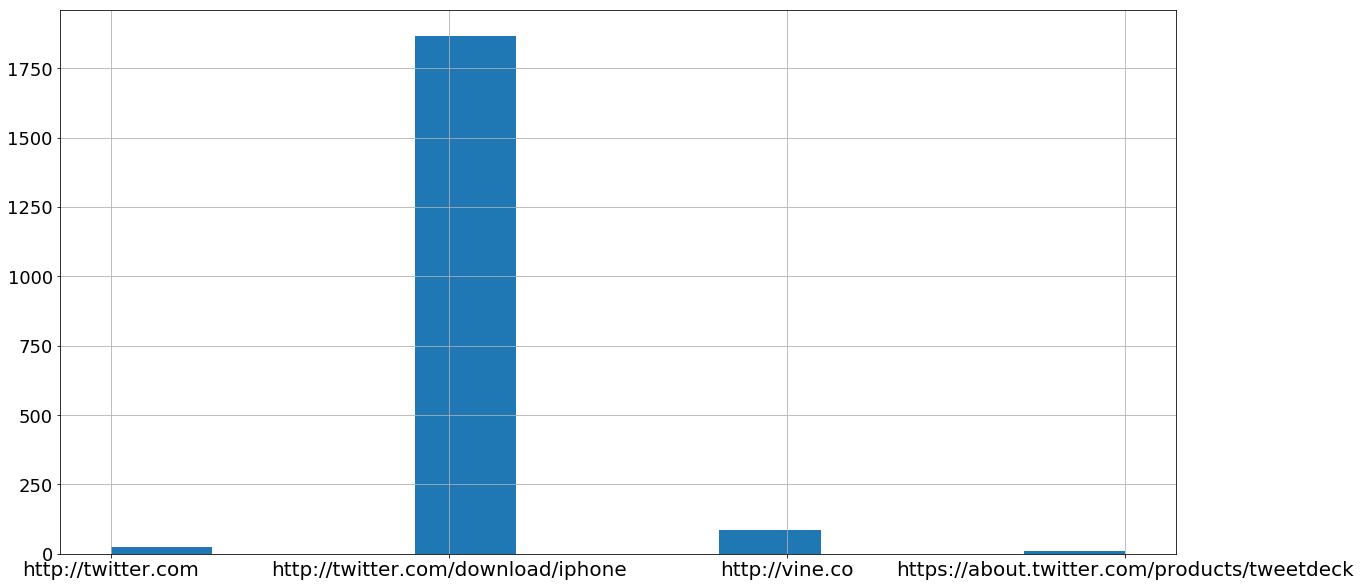

In [64]:
#Around 94% of tweets’ source is coming from “Twitter for iPhone” followed by “Vine - Make a Scene” [4.3%]
WeRateDogs_master_df.url.hist(figsize=(20,10),ylabelsize = 18, xlabelsize = 20)


In [65]:
#golden_retriever dogs are the most participating ones on the WeRateDogs Account
WeRateDogs_master_df.dog_class_prediction.value_counts()

golden_retriever               90
Pembroke                       61
Labrador_retriever             60
Chihuahua                      44
pug                            38
Pomeranian                     25
cocker_spaniel                 22
Samoyed                        21
chow                           20
French_bulldog                 19
toy_poodle                     17
malamute                       16
Chesapeake_Bay_retriever       15
seat_belt                      14
Shih-Tzu                       12
beagle                         12
Eskimo_dog                     12
Cardigan                       11
miniature_pinscher             11
Staffordshire_bullterrier      10
German_shepherd                10
Siberian_husky                 10
teddy                          10
Rottweiler                     10
Pekinese                        9
Shetland_sheepdog               9
vizsla                          8
Boston_bull                     8
West_Highland_white_terrier     8
Bernese_mounta